In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, beta, ortho_group
from scipy.interpolate import interp1d, CubicSpline, lagrange
from scipy.sparse.linalg import cg

%matplotlib inline

# $Ax = b$: conjugate gradient

For each linear problem, one can construct the new set of equivalent problems changing bases in column and row spaces:

\begin{equation}
  Ax = b \Longleftrightarrow \left(V^{T}AV\right) \left(V^{-1}x\right) = \left(V^{T}b\right).
\end{equation}

If one then applies an iterative method that solves a linear problem, different distributions over $V$ will produce in different distribution over $x^{n}$. The results for conjugate gradients are given below.

## Non-orthogonal transformation

If matrix $V$ is not orthogonal, the distribution over $x^{n}$ is nontrivial.

In [ ]:
np.random.seed(42)
D = 50
A = np.random.randn(D, D)
A = (A + A.T)/2
l, v = np.linalg.eigh(A)
A = (A + 3*np.eye(D)*np.min(l))
l, v = np.linalg.eigh(A)
sign = np.sign(l[0])
A = sign*A
b = np.random.randn(D)
x_exact = np.linalg.inv(A) @ b
x_0 = np.ones(D)

In [ ]:
np.random.seed(100)
N_samples = 5000
E = np.empty((2, N_samples))
for j, N_it in zip(range(2), [10, 30]):
  for i in range(N_samples):
    V = np.eye(D) + 0.1*np.random.randn(D, D)
    V_ = np.linalg.inv(V)
    B = V.T @ A @ V
    d = V.T @ b
    y_0 = V_ @ x_0
    s = cg(B, d, y_0, maxiter = N_it)
    e = np.linalg.norm(V @ s[0] - x_exact)
    E[j, i] = e

  E[j] = E[j] - np.mean(E[j])

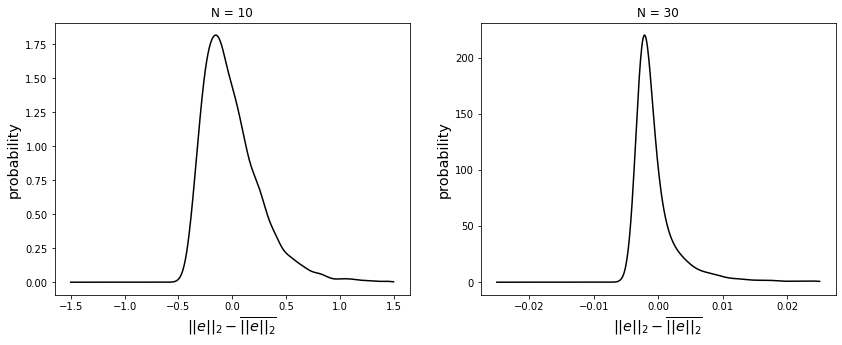

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

for j, N_it, L, R in zip(range(2), [10, 30], [-1.5, -0.025], [1.5, 0.025]):
  p = gaussian_kde(E[j])
  coords = np.linspace(L, R, 500)

  ax[j].plot(coords, p(coords), color='black')
  ax[j].set_xlabel(r'$\left\||e\right\||_2 - \overline{\left\||e\right\||_2}$', size='x-large')
  ax[j].set_title(f'N = {N_it}')
  ax[j].set_ylabel('probability', size='x-large');

## Orthogonal transformation

The conjugate gradient method is invariant under orthogonal transformations, so the resulting distribution is highly concentrated and of no use.

In [ ]:
np.random.seed(42)
D = 50
A = np.random.randn(D, D)
A = (A + A.T)/2
l, v = np.linalg.eigh(A)
A = (A + 3*np.eye(D)*np.min(l))
l, v = np.linalg.eigh(A)
sign = np.sign(l[0])
A = sign*A
b = np.random.randn(D)
x_exact = np.linalg.inv(A) @ b
x_0 = np.ones(D)

In [ ]:
np.random.seed(100)
N_samples = 5000
E = np.empty((2, N_samples))
for j, N_it in zip(range(2), [10, 30]):
  for i in range(N_samples):
    V = ortho_group.rvs(D)
    V_ = V.T
    B = V.T @ A @ V
    d = V.T @ b
    y_0 = V_ @ x_0
    s = cg(B, d, y_0, maxiter = N_it)
    e = np.linalg.norm(V @ s[0] - x_exact)
    E[j, i] = e

  E[j] = E[j] - np.mean(E[j])

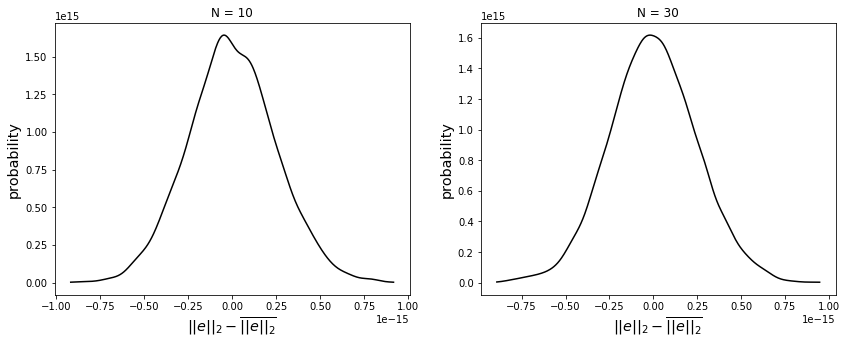

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

for j, N_it, L, R in zip(range(2), [10, 30], [-1.5, -0.025], [1.5, 0.025]):
  p = gaussian_kde(E[j])
  coords = np.linspace(np.min(E[j]), np.max(E[j]), 500)

  ax[j].plot(coords, p(coords), color='black')
  ax[j].set_xlabel(r'$\left\||e\right\||_2 - \overline{\left\||e\right\||_2}$', size='x-large')
  ax[j].set_title(f'N = {N_it}')
  ax[j].set_ylabel('probability', size='x-large');

Do not miss the scale. One can see the invariance of the CG under the orthogonal group.

# Integration: trapezoidal rule

Consider the real continuous function $f:\left[a, b\right]\rightarrow \mathbb{R}$, and the set of point $x_i = a + i\Delta x,~i=\overline{0, N}$, with $x_0 = a$ and $x_{N} = b$. Then the integral of a function $f$ can be approximated by a trapezoidal rule

\begin{equation}
 \int\limits_{a}^{b} f(x) dx \simeq \Delta x \left(\sum_{k=1}^{N-1} f\left(x_k\right) + \frac{f(a) + f(b)}{2}\right) \equiv \text{TZ}\left[f|N, a, b\right]
\end{equation}

The true value of the integral is a real number that does not depend on any particular parametrization, i.e. it is invariant under the change of variable $x$. Let us introduce a $N$-parametric family of bijective smooth coordinate transformations $g_{\eta}: \left[a, b\right]\rightarrow \left[a, b\right]$. If we change the variable $x = g_{\eta}(y)$, the resulting integral remains the same

\begin{equation}
 \int\limits_{a}^{b} f(x) dx = \int\limits_{g^{-1}_{\eta}(a)}^{g^{-1}_{\eta}(b)} f(g_{\eta}(y))\left|g^{'}_{\eta}(y)\right| dy.
\end{equation}

However, the trapezoidal rule will, in general, give different answers for different functions $g_{\xi}$. So, if one introduces a distribution over $\xi$, the resulting distribution over approximations to the integral will be nontrivial.

As an example of a concrete reparametrization, we consider a family $N\left(y| x_0, \xi\right)$ that is widely used to cluster point near the inner layer. First, we introduce the Ericson function

\begin{equation}
 E\left(y|\xi\right) = \frac{e^{\xi y} - 1}{e^{\xi} - 1},~\xi>0,~y\in\left[0, 1\right].
\end{equation}

If one uses the uniform grid for $y$, this function assures clustering of the nodes for $x = E\left(y|\xi\right)$ near the left edge of the interval. Below one can see a few examples for three different $\xi$ -- the variable that defines the thickness of the layer.

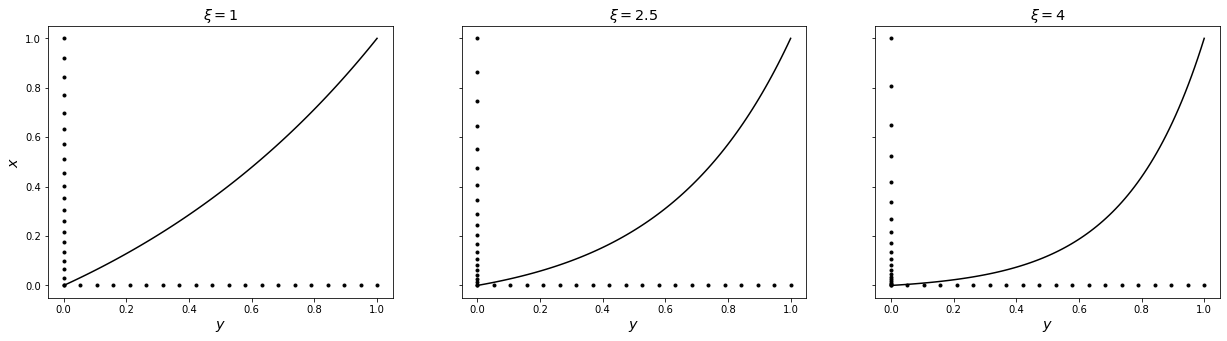

In [ ]:
y = np.linspace(0, 1, 20) # to show the uniform grid
z = np.linspace(0, 1, 100) # to draw a function
Ericson = lambda y, xi: (np.exp(xi*y) - 1)/(np.exp(xi) - 1)

fig, ax = plt.subplots(1, 3, figsize=(21, 5), sharey=True)
ax[0].set_ylabel(r'$x$', size='x-large')

for a, xi in zip(ax, [1, 2.5, 4]):
  a.plot(y, y*0, '.', color='black')
  a.plot(z, Ericson(z, xi), color='black')
  a.plot(y*0, Ericson(y, xi), '.', color='black')
  a.set_xlabel(r'$y$', size='x-large')
  a.set_title(rf'$\xi = {xi}$', size='x-large')


Using the Ericson function, one can construct a function that clusters nodes near the inner point of the interval

\begin{equation}
 N\left(y| x_0, \xi\right) = \begin{cases}
 x_0\left(1 - E\left(\left.1 - \frac{y}{x_0}\right|\xi\right)\right),\text{if } y\in\left[0, x_0\right];\\
 x_0 + \left(1 - x_0\right)E\left(\left.\frac{y - x_0}{1 - x_0}\right|\xi\right),\text{if } y\in\left[x_0, 1\right].
 \end{cases}
\end{equation}

Examples of three different $x_0$ are given below.

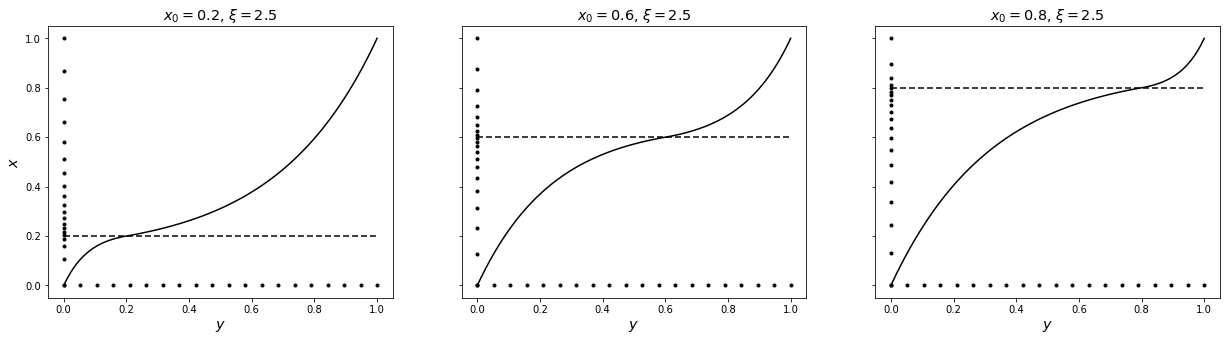

In [ ]:
y = np.linspace(0, 1, 20) # to show the uniform grid
z = np.linspace(0, 1, 100) # to draw a function
Inner_Ericson = lambda y, x0, xi=2.5: x0*(y<x0)*(1 - Ericson(1-y/x0, xi)) + (y>=x0)*(x0 + (1 - x0)*Ericson((y-x0)/(1-x0), xi))

fig, ax = plt.subplots(1, 3, figsize=(21, 5), sharey=True)
ax[0].set_ylabel(r'$x$', size='x-large')

for a, x0 in zip(ax, [0.2, 0.6, 0.8]):
  a.plot(y, y*0, '.', color='black')
  a.plot(z, Inner_Ericson(z, x0), color='black')
  a.plot(y*0, Inner_Ericson(y, x0), '.', color='black')
  a.plot(y, x0+0*y, dashes=[4, 2, 4, 2], color='black')
  a.set_xlabel(r'$y$', size='x-large')
  a.set_title(rf'$x_0 = {x0}$, $\xi = {2.5}$', size='x-large')

To cluster nodes near the point $c$ on the interval $\left[a, b\right]$ one can use $N\left(a + (b-a)y\left|(c-a)\big/(b-a), \xi\right.\right)$.

## Distribution over the scale

Let the integrand $f(x)$ be the probability density function of the normal distribution

\begin{equation}
  f(x) = \sqrt{\frac{20}{\pi}} \exp\left(-40\left(x-\frac{1}{2}\right)^2\right).
\end{equation}

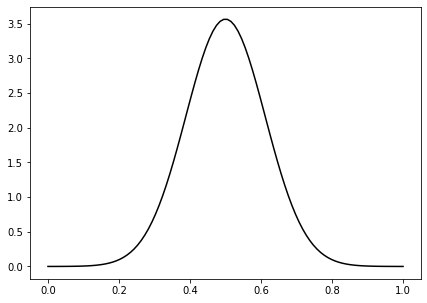

In [ ]:
z = np.linspace(0, 1, 100)
f = lambda x: np.sqrt(40/np.pi)*np.exp(-40*(x-.5)**2)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(z, f(z), color='black');

Since the variance is small, the value of the integral is approximately $1$. To construct a set of equivalent representations we find the derivative of $N_{\xi}(y|x_0)$:

\begin{equation}
 \partial_{y}N\left(y| x_0, \xi\right) = \begin{cases}
 E^{'}\left(\left.1 - \frac{y}{x_0}\right|\xi\right),\text{if } y\in\left[0, x_0\right];\\
 E^{'}\left(\left.\frac{y - x_0}{1 - x_0}\right|\xi\right),\text{if } y\in\left[x_0, 1\right].
 \end{cases},
\end{equation}

where the derivative of the Ericson function is

\begin{equation}
 E^{'}(y|\xi) = \xi\frac{e^{\xi y}}{e^{\xi} - 1}.
\end{equation}

Since $N_{\xi}(y|x_0)$ is smooth and one-to-one, we know that it does not change the value of the integral. Hence, one can put a distribution over $\xi$, and it will be purely subjective in the sense that the $\xi$ does not make a difference for the continuous problem. We set $x_0 = 0.5$, and as a distribution over $\xi$ we choose the Gamma distribution with probability density function of the form

\begin{equation}
 p(\xi|k, \theta) = \frac{\xi^{k-1}e^{-\frac{\xi}{\theta}}}{\Gamma(k)\theta^k}.
\end{equation}

Below one can see a kernel-density estimation (rbf) to the probability density of the value of the integral computed by the trapezoidal rule for $\theta = 4$, $k = 2$ and $\theta = 4$, $k = 4$.

In [ ]:
Ericson = lambda y, xi: (np.exp(xi*y) - 1)/(np.exp(xi) - 1)
d_Ericson = lambda y, xi: xi*np.exp(xi*y)/(np.exp(xi)-1)

Inner_Ericson = lambda y, xi, x0=0.5: x0*(y<x0)*(1 - Ericson(1-y/x0, xi)) + (y>=x0)*(x0 + (1 - x0)*Ericson((y-x0)/(1-x0), xi))
d_Inner_Ericson = lambda y, xi, x0=0.5: (y<x0)*d_Ericson(1-y/x0, xi) + (y>=x0)*d_Ericson((y-x0)/(1-x0), xi)

f = lambda x: np.sqrt(40/np.pi)*np.exp(-40*(x-.5)**2)
rep_f = lambda y, xi: abs(d_Inner_Ericson(y, xi))*f(Inner_Ericson(y, xi))

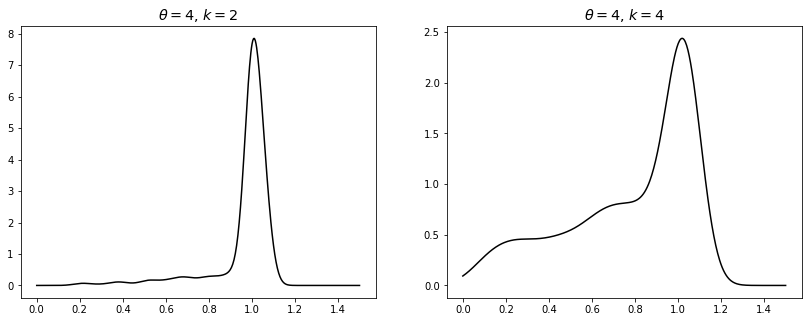

In [ ]:
N_samples = 1000

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
np.random.seed(42)

for scale, shape, a in zip([4, 4], [2, 4], ax):
  xi = np.random.gamma(shape, scale, N_samples)
  y = np.linspace(0, 1, 15)

  Integrals = np.empty(N_samples)
  for i in range(N_samples):
    Integrals[i] = np.trapz(rep_f(y, xi[i]), y)

  p = gaussian_kde(Integrals)
  coords = np.linspace(0, 1.5, 500)

  a.plot(coords, p(coords), color='black')
  a.set_title(rf'$\theta = {scale}$, $k = {shape}$', size='x-large')

The left tail of the distribution for $\theta = 4$, $k = 4$ corresponds to the too enthusiastic clustering. By construction, the distribution should converge to $\delta$-function when one increase the number of points. Below we can see a three estimated pdf for $N = 15, 30, 60$ and $\theta = 4$, $k = 4$.

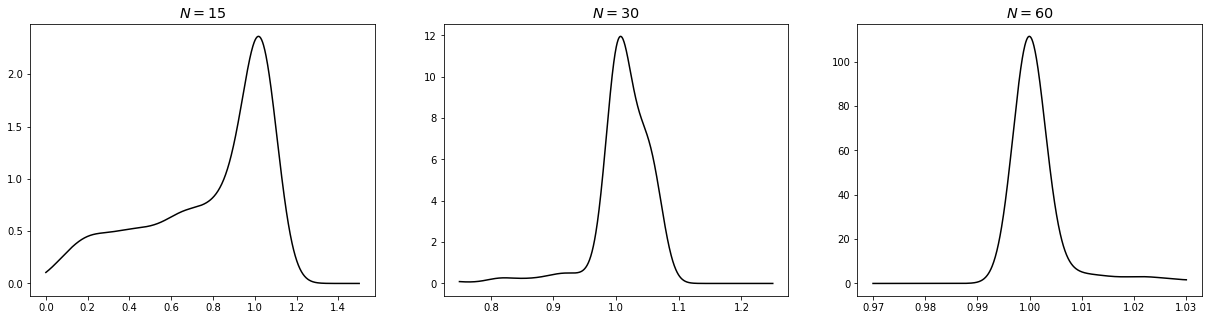

In [ ]:
N_samples = 1000

fig, ax = plt.subplots(1, 3, figsize=(21, 5))
scale, shape = 4, 4
np.random.seed(42)
xi = np.random.gamma(shape, scale, N_samples)

for N, a, L, R in zip([15, 30, 60], ax, [0, 0.75, 0.97], [1.5, 1.25, 1.03]):
  y = np.linspace(0, 1, N)

  Integrals = np.empty(N_samples)
  for i in range(N_samples):
    Integrals[i] = np.trapz(rep_f(y, xi[i]), y)

  p = gaussian_kde(Integrals)
  coords = np.linspace(L, R, 1000)

  a.plot(coords, p(coords), color='black')
  a.set_title(rf'$ N = {N}$', size='x-large')

The trend is evident. The distribution tends to the delta-function as expected.

## Distribution over the position

Let the integrand be

\begin{equation}
  f(x) = \left(x - \frac{1}{2}\right)\sqrt{\frac{20}{\pi}} \exp\left(-40\left(x-\frac{1}{2}\right)^2\right).
\end{equation}

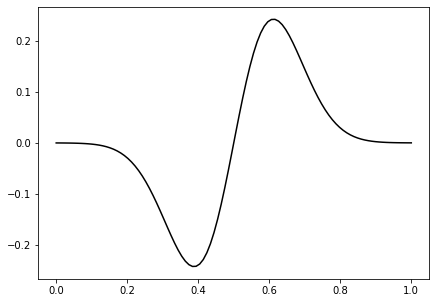

In [ ]:
z = np.linspace(0, 1, 100)
f = lambda x: (x-.5)*np.sqrt(40/np.pi)*np.exp(-40*(x-.5)**2)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(z, f(z), color='black');

The value of the integral is approximately zero. We use Beta distribution to draw values of $x_0$. Probability density function is
\begin{equation}
  p(x_0|\alpha, \beta) = \frac{x^{\alpha-1} (1-x)^{\beta-1}}{B(\alpha, \beta)}.
\end{equation}

Below we provide a three empirical pdf for $\left(\alpha, \beta\right) = (2, 5)$, $\left(\alpha, \beta\right) = (1/2, 1/2)$, $\left(\alpha, \beta\right) = (5, 2)$ with $\xi = 10$ in each case.

In [ ]:
Ericson = lambda y, xi: (np.exp(xi*y) - 1)/(np.exp(xi) - 1)
d_Ericson = lambda y, xi: xi*np.exp(xi*y)/(np.exp(xi)-1)

Inner_Ericson = lambda y, x0, xi=10: x0*(y<x0)*(1 - Ericson(1-y/x0, xi)) + (y>=x0)*(x0 + (1 - x0)*Ericson((y-x0)/(1-x0), xi))
d_Inner_Ericson = lambda y, x0, xi=10: (y<x0)*d_Ericson(1-y/x0, xi) + (y>=x0)*d_Ericson((y-x0)/(1-x0), xi)

f = lambda x: (x-.5)*np.sqrt(40/np.pi)*np.exp(-40*(x-.5)**2)
rep_f = lambda y, x0: abs(d_Inner_Ericson(y, x0))*f(Inner_Ericson(y, x0))

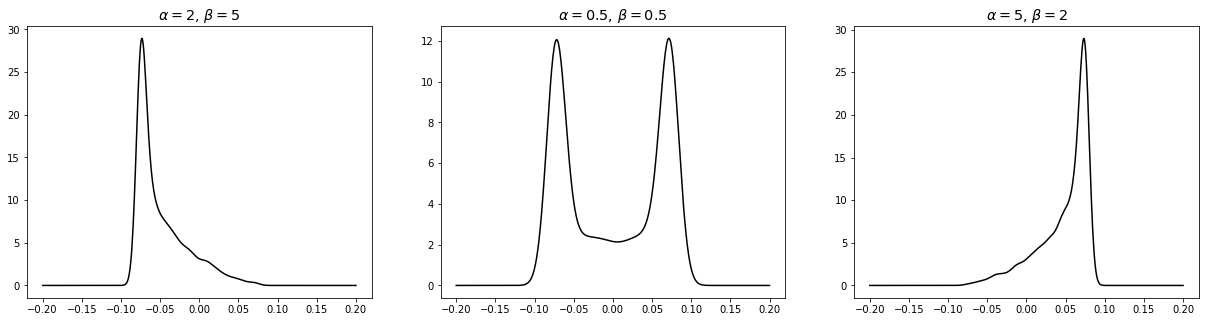

In [ ]:
N_samples = 5000
fig, ax = plt.subplots(1, 3, figsize=(21, 5))
np.random.seed(113)

for alpha, Beta, a in zip([2, .5, 5], [5, .5, 2], ax):
  np.random.seed(42)
  x0 = beta.rvs(alpha, Beta, size=N_samples)
  y = np.linspace(0, 1, 10)

  Integrals = np.empty(N_samples)
  for i in range(N_samples):
    Integrals[i] = np.trapz(rep_f(y, x0[i]), y)

  p = gaussian_kde(Integrals)
  coords = np.linspace(-0.2, 0.2, 500)

  a.plot(coords, p(coords), color='black')
  a.set_title(rf'$\alpha = {alpha}$, $\beta = {Beta}$', size='x-large')

The left (right) graph corresponds to the situations when grid points are clustered in the region where the function is negative (positive) and rarefied in all other regions. As a result, the value of the integral is negative (positive) with high probability. The middle graph exemplifies the symmetric situation and can be considered as an average of the left and right figures.

The example of the concentration of measure is given below.

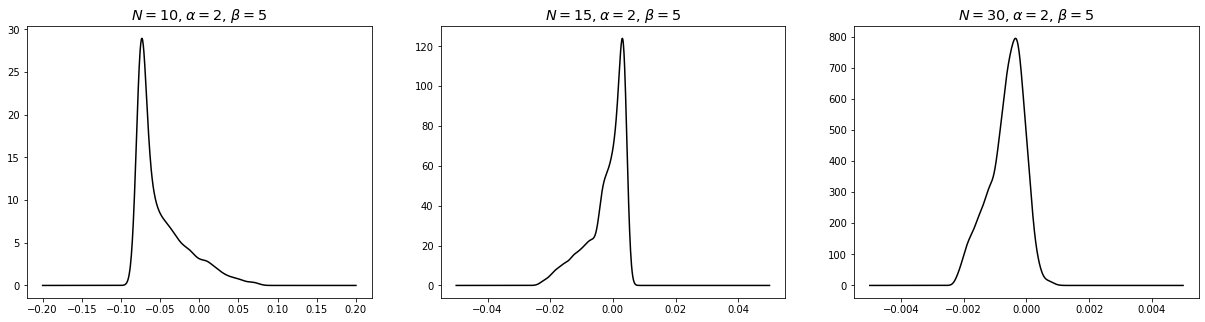

In [ ]:
N_samples = 5000

fig, ax = plt.subplots(1, 3, figsize=(21, 5))
alpha, Beta = 2, 5
np.random.seed(42)
x0 = beta.rvs(alpha, Beta, size=N_samples)

for N, a, L, R in zip([10, 15, 30], ax, [-.2, -.05, -.005,], [.2, .05, .005,]):
  y = np.linspace(0, 1, N)

  Integrals = np.empty(N_samples)
  for i in range(N_samples):
    Integrals[i] = np.trapz(rep_f(y, x0[i]), y)

  p = gaussian_kde(Integrals)
  coords = np.linspace(L, R, 1000)

  a.plot(coords, p(coords), color='black')
  a.set_title(rf'$N = {N}, \alpha = {alpha}$, $\beta = {Beta}$', size='x-large')

Again, the concentration of measure is evident. Even though we started from an apparently biased assumption about the node distribution, the measure will eventually even out.

### Supplementary

This part contains a code that reproduces two figures we used in the article in the section devoted to trapezoidal rule.

In [ ]:
Ericson = lambda y, xi: (np.exp(xi*y) - 1)/(np.exp(xi) - 1)
Inner_Ericson = lambda y, x0, xi=10: x0*(y<x0)*(1 - Ericson(1-y/x0, xi)) + (y>=x0)*(x0 + (1 - x0)*Ericson((y-x0)/(1-x0), xi))

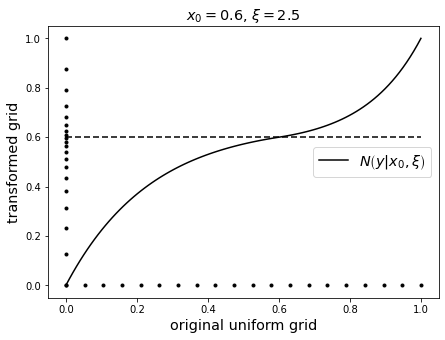

In [ ]:
y = np.linspace(0, 1, 20) # to show the uniform grid
z = np.linspace(0, 1, 100) # to draw a function
Inner_Ericson = lambda y, x0, xi=2.5: x0*(y<x0)*(1 - Ericson(1-y/x0, xi)) + (y>=x0)*(x0 + (1 - x0)*Ericson((y-x0)/(1-x0), xi))

fig, ax = plt.subplots(1, 1, figsize=(7, 5), sharey=True)
ax.set_ylabel('transformed grid', size='x-large')
x0 = 0.6
ax.plot(y, y*0, '.', color='black')
ax.plot(z, Inner_Ericson(z, x0), color='black', label=r'$N\left(y|x_0,\xi\right)$')
ax.plot(y*0, Inner_Ericson(y, x0), '.', color='black')
ax.plot(y, x0+0*y, dashes=[4, 2, 4, 2], color='black')
ax.set_xlabel('original uniform grid', size='x-large')
ax.set_title(rf'$x_0 = {x0}$, $\xi = {2.5}$', size='x-large')
ax.legend(fontsize='x-large');
plt.savefig('grid_transformation.pdf', format='pdf')

In [ ]:
Ericson = lambda y, xi: (np.exp(xi*y) - 1)/(np.exp(xi) - 1)
d_Ericson = lambda y, xi: xi*np.exp(xi*y)/(np.exp(xi)-1)

Inner_Ericson = lambda y, x0, xi=10: x0*(y<x0)*(1 - Ericson(1-y/x0, xi)) + (y>=x0)*(x0 + (1 - x0)*Ericson((y-x0)/(1-x0), xi))
d_Inner_Ericson = lambda y, x0, xi=10: (y<x0)*d_Ericson(1-y/x0, xi) + (y>=x0)*d_Ericson((y-x0)/(1-x0), xi)

f = lambda x: (x-.5)*np.sqrt(40/np.pi)*np.exp(-40*(x-.5)**2)
rep_f = lambda y, x0: abs(d_Inner_Ericson(y, x0))*f(Inner_Ericson(y, x0))

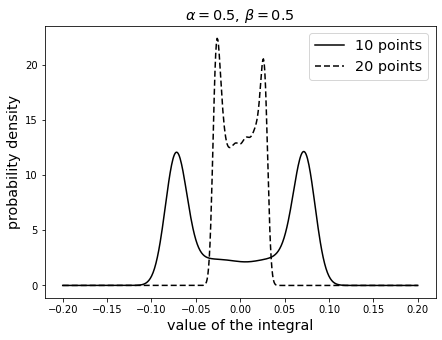

In [ ]:
N_samples = 5000
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

alpha, Beta = .5, .5
np.random.seed(42)
x0 = beta.rvs(alpha, Beta, size=N_samples)

y = np.linspace(0, 1, 10)

Integrals = np.empty(N_samples)
for i in range(N_samples):
  Integrals[i] = np.trapz(rep_f(y, x0[i]), y)

p = gaussian_kde(Integrals)
coords = np.linspace(-0.2, 0.2, 500)

ax.plot(coords, p(coords), color='black', label='10 points')

x0 = beta.rvs(alpha, Beta, size=N_samples)
y = np.linspace(0, 1, 20)

Integrals = np.empty(N_samples)
for i in range(N_samples):
  Integrals[i] = np.trapz(rep_f(y, x0[i]), y)

p = gaussian_kde(Integrals)
coords = np.linspace(-0.2, 0.2, 500)

ax.plot(coords, p(coords), dashes=[4, 2, 4, 2], color='black', label='20 points')

ax.set_xlabel('value of the integral', fontsize='x-large')
ax.set_ylabel('probability density', size='x-large')
ax.set_title(rf'$\alpha = {alpha}$, $\beta = {Beta}$', size='x-large')
ax.legend(fontsize='x-large');
plt.savefig('trapezoidal_rule_distribution.pdf', format='pdf')

# Leading eigenvalue by power iteration

Consider the eigenproblem

\begin{equation}
 Ax = \lambda x.
\end{equation}

To find an eigenvalue $\lambda_{\max}$ with the largest absolut value, one can apply a simple scheme known as a power iteration

\begin{equation}
 x^{n+1} = \frac{Ax^n}{\left\|Ax^{n}\right\|_2},~\lambda_{\max}^{n+1} = \frac{\left(x^{n+1}, A x^{n+1}\right)}{\left(A x^{n+1}, A x^{n+1}\right)}
\end{equation}

The convergence of the algorithm is well understood. In case the subspace corresponding to the eigenvalue $\lambda_{\max}$ of the largest absolute value consists of a single eigenvector (no other eigenvectors or generalized eigenvectors with the same eigenvalue) and the initial vector is not orthogonal to that subspace, one has $x^{n} \rightarrow \mu,~\lambda^{n} \rightarrow \lambda_{\max}: A\mu = \lambda_{\max} \mu$.

Suppose one perform a similarity transformation with some non-degenerate matrix $V$, i.e.

\begin{equation}
 VAV^{-1} Vx = \lambda V x,~\widetilde{A} \equiv VAV^{-1},~\widetilde{x} \equiv Vx.
\end{equation}

In the new bases power iteration will look like exactly like the iterations for the original matrix, but with $\widetilde{x}$, $\widetilde{A}$ in place of $x$ and $A$. Since the similarity transformation does not change the spectrum $\widetilde{\lambda}^{n}_{\max} \rightarrow \lambda_{\max}$. However for the finite $n$ in general $\lambda^{n}_{\max} \neq \widetilde{\lambda}^{n}_{\max}$.

To demonstrate this, we introduce the distribution over $V$
\begin{equation}
 V =
 \begin{pmatrix}
 a & 0\\
 0 & 1
 \end{pmatrix}
 \begin{pmatrix}
 \cos\phi & -\sin\phi \\
 \sin\phi & \cos\phi
 \end{pmatrix},~p(\phi) = \text{Ind}\left[\phi \in \left[0, \frac{\pi}{2}\right]\right].
\end{equation}
and choose the matrix and the initial vector as follows
\begin{equation}
 A = v v^T + (1 + \epsilon)u u^T,
 v = \frac{1}{\sqrt{2}}\begin{pmatrix}
 1\\
 -1
 \end{pmatrix},
 u = \frac{1}{\sqrt{2}}\begin{pmatrix}
 1\\
 1
 \end{pmatrix},
 x_0 = \begin{pmatrix}
 1\\
 2\\
 \end{pmatrix}.
\end{equation}

In the simulation below we use $a = 1/2$, $\epsilon = 10^{-2}$.

In [ ]:
def power_iteration(A, x0):
  r = A @ x0
  s = np.linalg.norm(r)
  return r / s

def sample_l_max(A, x0, N_it=40):
  phi = np.pi*np.random.rand()/2
  B = np.array([[.5, 0], [0, 1]])
  V = B @ np.array([[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]])
  V_ = np.linalg.inv(V)
  wave_x0 = V @ x0
  wave_A = V @ A @ V_

  for _ in range(N_it):
    wave_x0 = power_iteration(wave_A, wave_x0)

  wave_l_max = np.dot(wave_x0, wave_A @ wave_x0) / np.dot(wave_x0, wave_x0)
  return wave_l_max

In [ ]:
u = np.array([1, -1])/np.sqrt(2)
v = np.array([1, 1])/np.sqrt(2)
epsilon = 1e-2
A = np.outer(u, u) + (1 + epsilon)*np.outer(v, v)
#A = np.array([[1, 1], [0, 1 + 1e-4]])
x0 = np.array([1, 2])
l_exact = 1 + epsilon
N_samples = 5000
#np.random.seed(43)
delta_L = np.empty((3, N_samples))

for j, N_it in enumerate([10, 40, 160]):
  for i in range(N_samples):
    delta_L[j, i] = (l_exact - sample_l_max(A, x0, N_it = N_it))/epsilon

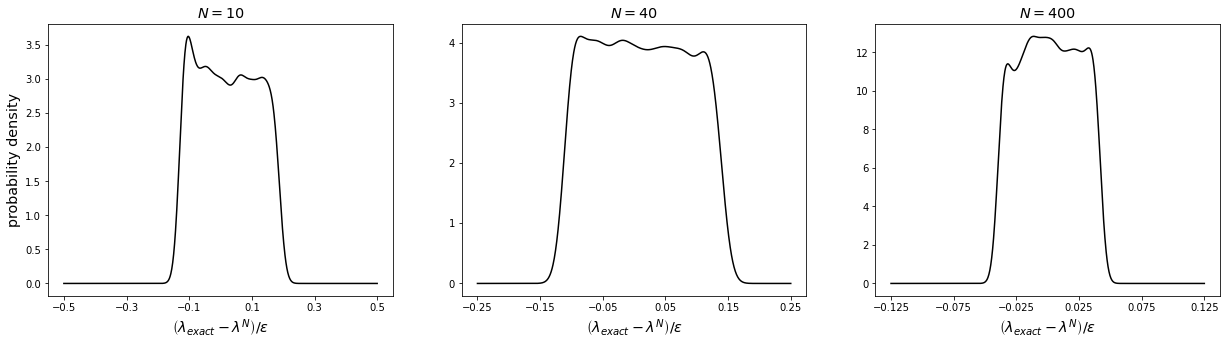

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(21, 5))

for d_L, a, N, L, R in zip(delta_L, ax, [10, 40, 400], [-0.5, -0.25, -0.125], [0.5, 0.25, 0.125]):

  p = gaussian_kde(d_L)
  coords = np.linspace(L, R, 1000)

  a.plot(coords, p(coords), color='black')
  a.set_title(rf'$N = {N}$', size='x-large')
  a.set_xlabel(r'$\left(\lambda_{exact} - \lambda^{N}\right)/\epsilon$', size='x-large')
  a.set_xticks(np.linspace(L, R, 6))

ax[0].set_ylabel('probability density', fontsize='x-large');

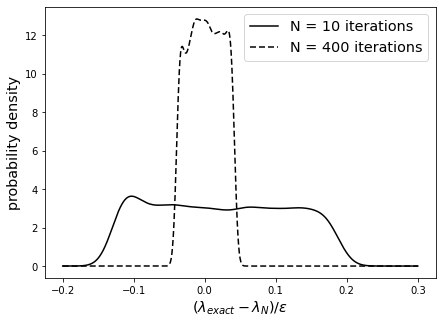

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
p1 = gaussian_kde(delta_L[0])
p2 = gaussian_kde(delta_L[2])
coords = np.linspace(-0.2, 0.3, 1000)
ax.plot(coords, p1(coords), color='black', label='N = 10 iterations')
ax.plot(coords, p2(coords), dashes=[4, 2, 4, 2], color='black', label='N = 400 iterations')
ax.set_xlabel(r'$\left(\lambda_{exact} - \lambda_{N}\right)/\epsilon$', size='x-large')
ax.legend(fontsize='x-large')
ax.set_ylabel('probability density', fontsize='x-large');
plt.savefig('power.pdf', format='pdf')

Again, we see that measure is concentrated as the approximation becomes better.

# Approximation/ Interpolation/ Derivatives

Consider the problem of iterpolation from data
\begin{equation}
    \left\{f(x_i)\right\}_{i=\overline{1, K}}
\end{equation}
One solution of this simple interpolation problem is to use the Lagrange polynomial
\begin{equation}
    \hat{f}(x) = \sum_{i=1}^{K}f(x_i)p_{i}(x),~p_{i}(x) = \prod_{k\neq i}\frac{x-x_{k}}{x_{i}-x_{k}}.
\end{equation}
Now, suppose we knew the values of a function at all points of the interval of interest, i.e. $f(x)$. In this case, the trivial transformation with arbitrary invertible function $g_{\xi}^{-1}\left(g_{\xi}\left(f(x)\right)\right)$ changes nothing. In particular, the original data remain intact. On the other hand, this transformation leads to the modification of that reads
\begin{equation}
    \hat{f}_{\xi}(x) \equiv g_{\xi}^{-1}\left(\sum_{i=1}^{K}g_{\xi}\left(f\left(x_i\right)\right)p_{i}(x)\right)\neq\hat{f}(x).
\end{equation}

The same pair of transormations $g_{\xi}, g_{\xi}^{-1}$ can be applied for any other interpolation, f.e., cubic splines. Below we consider examples with
\begin{equation}
\begin{split}
&g_{\xi}(x) = \exp(-\xi x),~g_{\xi}^{-1} = -\log(x)\big/\xi,\\
&p(\xi) = \text{Ind}\left[\xi \in \left[-1, 3\right]\right];
\end{split}
\end{equation}
for cubic splines and lagrange interpolation.

## Cubic spline

In [ ]:
f = lambda x: 1 + np.cos(np.pi*x)
g = lambda x, xi: np.exp(-xi*x)
g_ = lambda x, xi: -np.log(x)/xi

df = lambda x: -np.pi*np.sin(np.pi*x)
dg_ = lambda x, xi: -1/(xi*x)

In [ ]:
z = np.linspace(-1, 1, 100)
x = [np.linspace(-1, 1, 6), np.linspace(-1, 1, 12)]
np.random.seed(23)

N_samples = 50
int_samples = np.empty((2, N_samples, 100))

for k in range(2):
  for i in range(N_samples):
    xi_ = 4*np.random.uniform() - 1
    j = lambda x, xi=xi_: g(f(x), xi=xi)
    y_ = j(x[k])
    u_ = CubicSpline(x[k], y_)
    int_samples[k, i] = g_(u_(z), xi=xi_)

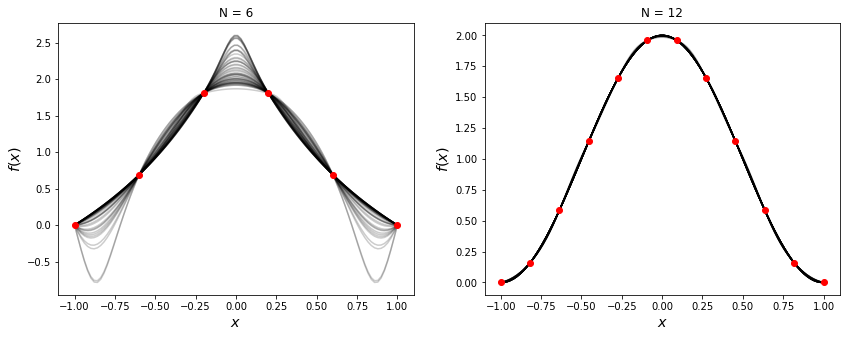

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

for k in range(2):
  for int_f in int_samples[k]:
    ax[k].plot(z, int_f, color='black', alpha=0.2)
  ax[k].set_xlabel('$x$', size='x-large')
  ax[k].set_ylabel('$f(x)$', size='x-large')
  ax[k].plot(x[k], f(x[k]), 'o', color='red')
  ax[k].set_title(f'N = {len(x[k])}')

In [ ]:
z = np.linspace(-1, 1, 100)
x = [np.linspace(-1, 1, 6), np.linspace(-1, 1, 12)]
np.random.seed(33)

N_samples = 50
int_samples = np.empty((2, N_samples, 100))

for k in range(2):
  for i in range(N_samples):
    xi_ = 4*np.random.uniform() - 1
    j = lambda x, xi=xi_: g(f(x), xi=xi)
    y_ = j(x[k])
    u_ = CubicSpline(x[k], y_)
    du_ = u_.derivative()
    int_samples[k, i] = dg_(u_(z), xi=xi_)*du_(z)

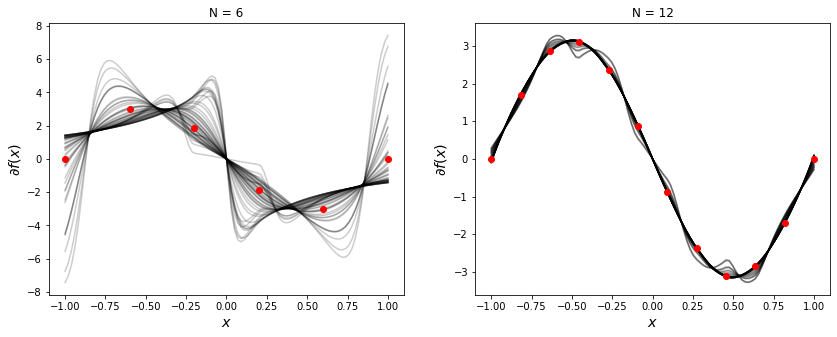

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

for k in range(2):
  for int_f in int_samples[k]:
    ax[k].plot(z, int_f, color='black', alpha=0.2)
  ax[k].set_xlabel('$x$', size='x-large')
  ax[k].set_ylabel(r"$\partial f(x)$", size='x-large')
  ax[k].plot(x[k], df(x[k]), 'o', color='red')
  ax[k].set_title(f'N = {len(x[k])}')

## Lagrange polynomial

In [ ]:
z = np.linspace(-1, 1, 100)
x = [np.linspace(-1, 1, 6), np.linspace(-1, 1, 12)]
np.random.seed(23)

N_samples = 50
int_samples = np.empty((2, N_samples, 100))

for k in range(2):
  for i in range(N_samples):
    xi_ = 4*np.random.uniform() - 1
    j = lambda x, xi=xi_: g(f(x), xi=xi)
    y_ = j(x[k])
    u_ = lagrange(x[k], y_)
    int_samples[k, i] = g_(u_(z), xi=xi_)

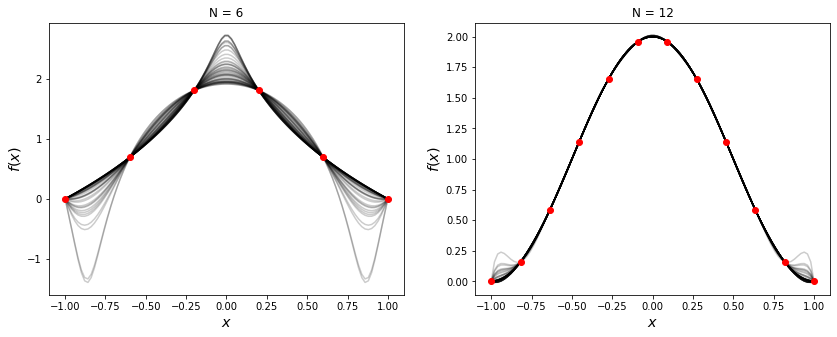

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

for k in range(2):
  for int_f in int_samples[k]:
    ax[k].plot(z, int_f, color='black', alpha=0.2)
  ax[k].set_xlabel('$x$', size='x-large')
  ax[k].set_ylabel('$f(x)$', size='x-large')
  ax[k].plot(x[k], f(x[k]), 'o', color='red')
  ax[k].set_title(f'N = {len(x[k])}')

In [ ]:
z = np.linspace(-1, 1, 100)
x = [np.linspace(-1, 1, 6), np.linspace(-1, 1, 12)]
np.random.seed(33)

N_samples = 50
int_samples = np.empty((2, N_samples, 100))

for k in range(2):
  for i in range(N_samples):
    xi_ = 4*np.random.uniform() - 1
    j = lambda x, xi=xi_: g(f(x), xi=xi)
    y_ = j(x[k])
    u_ = lagrange(x[k], y_)
    du_ = u_.deriv()
    int_samples[k, i] = dg_(u_(z), xi=xi_)*du_(z)

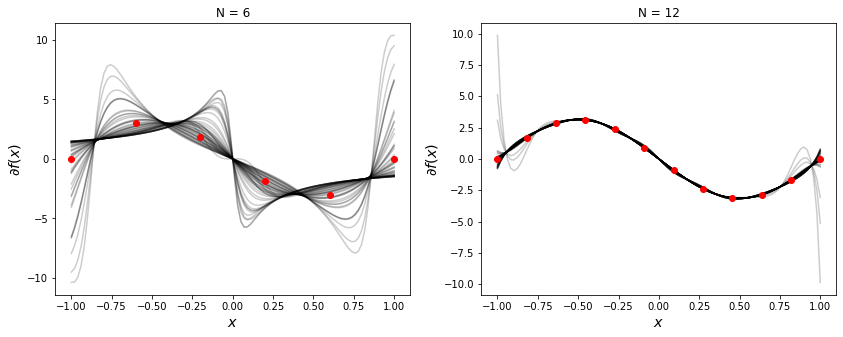

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

for k in range(2):
  for int_f in int_samples[k]:
    ax[k].plot(z, int_f, color='black', alpha=0.2)
  ax[k].set_xlabel('$x$', size='x-large')
  ax[k].set_ylabel(r"$\partial f(x)$", size='x-large')
  ax[k].plot(x[k], df(x[k]), 'o', color='red')
  ax[k].set_title(f'N = {len(x[k])}')

In [ ]:
int_samples = np.empty((2, N_samples, 100))
x = np.linspace(-1, 1, 6)

for i in range(N_samples):
  xi_ = 4*np.random.uniform() - 1
  j = lambda x, xi=xi_: g(f(x), xi=xi)
  y_ = j(x)
  u_ = lagrange(x, y_)
  du_ = u_.deriv()
  int_samples[0, i] = g_(u_(z), xi=xi_)
  int_samples[1, i] = dg_(u_(z), xi=xi_)*du_(z)

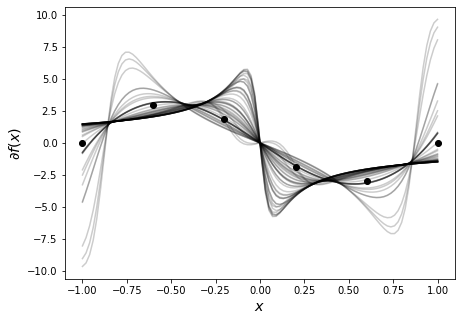

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

for c in int_samples[1]:
  ax.plot(z, c, color='black', alpha=0.2)
ax.set_xlabel('$x$', size='x-large')
ax.set_ylabel(r"$\partial f(x)$", size='x-large')
ax.plot(x, df(x), 'o', color='black')
plt.savefig('df_int.pdf', format='pdf');

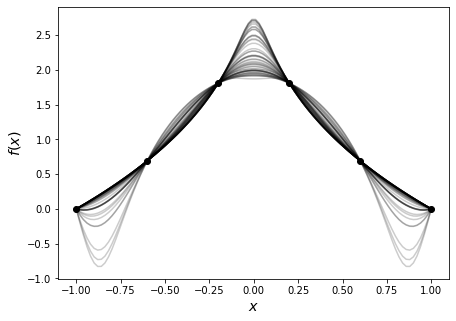

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

for c in int_samples[0]:
  ax.plot(z, c, color='black', alpha=0.2)
ax.set_xlabel('$x$', size='x-large')
ax.set_ylabel('$f(x)$', size='x-large')
ax.plot(x, f(x), 'o', color='black')
plt.savefig('f_int.pdf', format='pdf');

# Nonlinear algebraic equations: Newton's method

The widely known technique for the solution of nonlinear algebraic equations of the form $g(x) = 0$ is Newton's method. For the scalar equation, the single-step reads

\begin{equation}
 x^{n+1} = x^{n} - \frac{g(x^{n})}{g^{'}(x^{n})}.
\end{equation}

It is always possible to reparametrise the initial equation using any function $f_{\xi}(x)$ (1-parametric family with different functions corresponding to different $\xi$) that is defined over the range of $g$, $f_{\xi}(x) = 0 \Leftrightarrow x = 0$ and $\forall x f^{'}(x) \neq 0$. Under this condition any root of the original equation $g(x) = 0$ is also a root of the modified equation $f_{\xi}(g(x)) = 0$. So it is quiet obvious that any distribution over $\xi$ does not affect the exact solution. Newertheless, it does affect the solution after the finite number of iterations.

As an example we consider the function $g(x) = (x-2)(x+3)$. 

In [ ]:
Newton = lambda g, dg, x0: x0 - g(x0)/dg(x0)

g = lambda x: (x-2)*(x+3)
dg = lambda x: 2*x + 1

f = lambda y, xi: (np.exp(xi*y) - 1)/(np.exp(xi) - 1)
df = lambda y, xi: xi*np.exp(xi*y)/(np.exp(xi)-1)

In [ ]:
N_samples = 5000
X = np.empty((2, N_samples))
N_it = [20, 50]
np.random.seed(101)

for i in range(2):
  for j in range(N_samples):
    xi = np.random.randn()*0.1
    l = lambda x, xi = xi: f(g(x), xi)
    dl = lambda x, xi = xi: df(g(x), xi)*dg(x)

    x1 = 0
    for _ in range(N_it[i]):
      x1 = Newton(l, dl, x1)

    X[i, j] = x1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in double_scalars
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


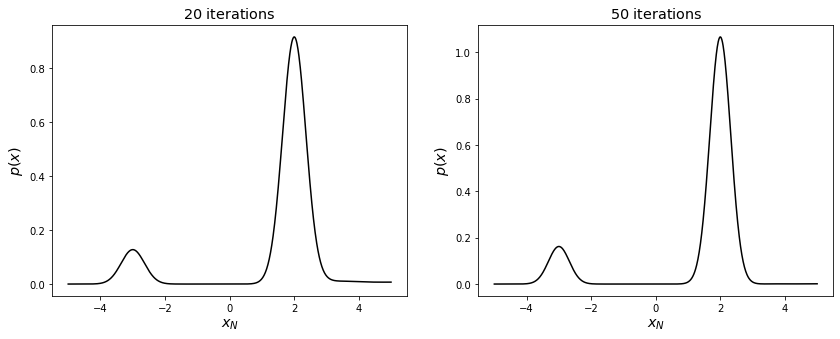

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

for xx, a, N in zip(X, ax, N_it):

  p = gaussian_kde(xx[abs(xx)<10])
  coords = np.linspace(-5, 5, 1000)

  a.plot(coords, p(coords), color='black')
  a.set_title(rf'${N}$ iterations', size='x-large')
  a.set_xlabel(r'$x_{N}$', size='x-large')
  #a.set_xticks(np.linspace(np.min(xx), np.max(xx), 4))
  a.set_ylabel('$p(x)$', size='x-large')
  #a.ticklabel_format(style='sci', scilimits=(0, 0), useOffset=False, useMathText=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


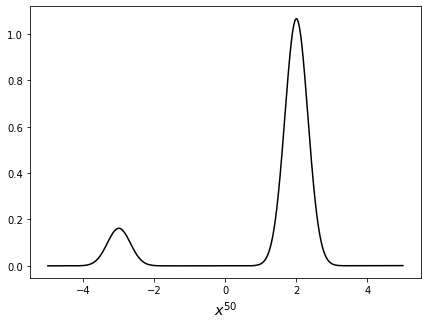

In [ ]:
fig, a = plt.subplots(1, 1, figsize=(7, 5))

p = gaussian_kde(X[1][abs(X[1])<10])
coords = np.linspace(-5, 5, 1000)

a.plot(coords, p(coords), color='black')
a.set_xlabel(r'$x^{50}$', size='x-large');
plt.savefig('newton.pdf', format='pdf')